In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from collections import Counter
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import xgboost as xgb #Gradient boosting

from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel #model selection
from sklearn.metrics import accuracy_score #model testing
import matplotlib.mlab as mlab  

In [2]:
train = pd.read_csv("/Users/dingding/Desktop/we_data/train.csv")
validation = pd.read_csv("/Users/dingding/Desktop/we_data/validation.csv")
test=pd.read_csv('/Users/dingding/Desktop/we_data/test.csv')

# Preprocess Data

In [3]:
def preprocessData(data):
    click=data['click']
    weekday=pd.get_dummies(data['weekday'],prefix='weekday_')
    hour=pd.get_dummies(data['hour'],prefix='hour_')
    useragent=pd.get_dummies(data['useragent'],prefix='useragent_')
    region=pd.get_dummies(data['region'],prefix='region_')
    city=pd.get_dummies(data['city'],prefix='city_')
    adexchange=pd.get_dummies(data['adexchange'],prefix='adexchange_')
    slotwidth=pd.get_dummies(data['slotwidth'],prefix='slotwidth_')
    slotheight=pd.get_dummies(data['slotheight'],prefix='slotheight_')
    slotvisibility=pd.get_dummies(data['slotvisibility'],prefix='slotvisibility_')
    slotformat=pd.get_dummies(data['slotformat'],prefix='slotformat_')
    slotprice=data['slotprice']
    creative=pd.get_dummies(data['creative'],prefix='creative_')
    keypage=pd.get_dummies(data['keypage'],prefix='keypage_')
    advertiser=pd.get_dummies(data['advertiser'],prefix='advertiser_')
    
    data_usertag=data.usertag.fillna('0')
    data_usertag=data_usertag.str.replace(',',' ')
    vect=CountVectorizer()
    data_usertag_vect=vect.fit_transform(data_usertag)
    usertag=pd.DataFrame(data_usertag_vect.toarray(),columns=vect.get_feature_names())
    
    newdata=pd.concat([click,weekday,hour,useragent,region,city,adexchange,\
                       slotwidth,slotheight,slotvisibility,slotformat,\
                       slotprice,creative,keypage,advertiser,usertag],axis=1)
    
    return newdata

In [4]:
def preprocessTestData(data):
    weekday=pd.get_dummies(data['weekday'],prefix='weekday_')
    hour=pd.get_dummies(data['hour'],prefix='hour_')
    useragent=pd.get_dummies(data['useragent'],prefix='useragent_')
    region=pd.get_dummies(data['region'],prefix='region_')
    city=pd.get_dummies(data['city'],prefix='city_')
    adexchange=pd.get_dummies(data['adexchange'],prefix='adexchange_')
    slotwidth=pd.get_dummies(data['slotwidth'],prefix='slotwidth_')
    slotheight=pd.get_dummies(data['slotheight'],prefix='slotheight_')
    slotvisibility=pd.get_dummies(data['slotvisibility'],prefix='slotvisibility_')
    slotformat=pd.get_dummies(data['slotformat'],prefix='slotformat_')
    slotprice=data['slotprice']
    creative=pd.get_dummies(data['creative'],prefix='creative_')
    keypage=pd.get_dummies(data['keypage'],prefix='keypage_')
    advertiser=pd.get_dummies(data['advertiser'],prefix='advertiser_')
    
    data_usertag=data.usertag.fillna('0')
    data_usertag=data_usertag.str.replace(',',' ')
    vect=CountVectorizer()
    data_usertag_vect=vect.fit_transform(data_usertag)
    usertag=pd.DataFrame(data_usertag_vect.toarray(),columns=vect.get_feature_names())
    
    newdata=pd.concat([weekday,hour,useragent,region,city,adexchange,\
                       slotwidth,slotheight,slotvisibility,slotformat,\
                       slotprice,creative,keypage,advertiser,usertag],axis=1)
    
    return newdata

In [5]:
train_processed=preprocessData(train)

In [6]:
validation_processed=preprocessData(validation)

In [7]:
test_processed=preprocessTestData(test)

In [8]:
print('Number of features in processed training set',len(train_processed.columns))
print('Number of features in processed validation set',len(validation_processed.columns))
print('Number of features in processed test set',len(test_processed.columns))

Number of features in processed training set 756
Number of features in processed validation set 751
Number of features in processed test set 748


In [9]:
train_features=list(train_processed)
validation_features=list(validation_processed)
test_features=list(test_processed)

In [10]:
print(list(set(train_features)-set(validation_features)))
print(list(set(validation_features)-set(train_features)))
print(list(set(train_features)-set(test_features)))
print(list(set(test_features)-set(train_features)))

['useragent__android_ie', 'creative__7324', 'useragent__other_firefox', 'creative__7332', 'useragent__android_maxthon']
[]
['click', 'creative__7324', 'useragent__mac_sogou', 'useragent__linux_ie', 'useragent__other_firefox', 'creative__7327', 'useragent__mac_maxthon', 'useragent__android_ie']
[]


In [11]:
remove_features=['click', 'useragent__android_maxthon', 'useragent__linux_ie', 'creative__7324', 'useragent__other_firefox',\
                 'creative__7332', 'creative__7327', 'useragent__android_ie', 'useragent__mac_sogou', 'useragent__mac_maxthon']
feature=[]
for i in train_features:
    if(i not in remove_features):
        feature.append(i)

In [12]:
len(feature)

746

In [13]:
print(list(set(feature)-set(validation_features)))
print(list(set(validation_features)-set(feature)))
print(list(set(feature)-set(test_features)))
print(list(set(test_features)-set(feature)))

[]
['useragent__mac_sogou', 'useragent__linux_ie', 'click', 'useragent__mac_maxthon', 'creative__7327']
[]
['creative__7332', 'useragent__android_maxthon']


In [14]:
train_processed.click.value_counts()

0    2429188
1       1793
Name: click, dtype: int64

In [15]:
validation.click.value_counts()

0    303723
1       202
Name: click, dtype: int64

# Train Model

In [16]:
downsampling_rate=0.025

In [17]:
train_not_clicked = train_processed[train_processed.click == 0].sample(n= round(downsampling_rate*2429188), random_state = 2)
train_clicked = train_processed[train_processed.click == 1]
train_sample = pd.concat([train_clicked,train_not_clicked],0)

In [18]:
train_set=train_sample[feature]
train_label=train_sample['click']
validation_set=validation_processed[feature]
validation_label=validation_processed['click']


In [19]:
test_set=test_processed[feature]

# Choose a better classfier model through comparing AUC

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

/Users/dingding/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


/Users/dingding/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/dingding/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/dingding/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


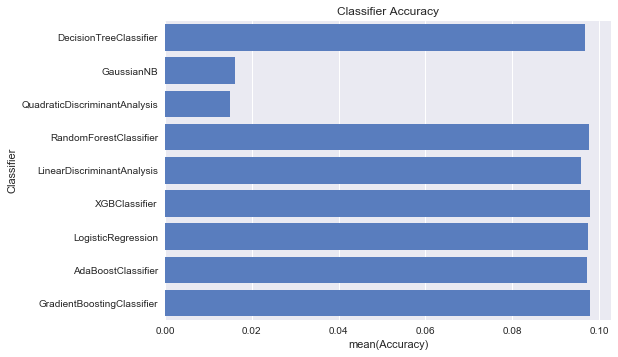

In [109]:
classifiers = [
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)



acc_dict = {}

X_train, X_test, y_train, y_test = train_test_split(train_set,train_label,test_size=0.33, random_state=42)


for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.show()

# Tuning the parameter for GDBT and XGboost

In [21]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['click'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #Print Feature Importance:
    if performCV and printFeatureImportance: 
        
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['click'], cv=cv_folds, scoring='roc_auc')
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
       
        
    #Perform cross-validation:
    #if performCV:
        
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['click'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['click'], dtrain_predprob))
    
    
        
    

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from sklearn.cross_validation import KFold

from sklearn.cross_validation import StratifiedKFold

/Users/dingding/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [112]:
target = 'click'
IDcol = 'click'
predictors = [x for x in train_sample.columns if x not in [target, IDcol]]
gbm0 = XGBClassifier(random_state=10)
modelfit(gbm0, train_sample, predictors)

CV Score : Mean - 0.853859 | Std - 0.006320841 | Min - 0.8459125 | Max - 0.8636338

Model Report
Accuracy : 0.9799
AUC Score (Train): 0.875726


## Tune the n estimoators

In [113]:
predictors = [x for x in train_sample.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':list(range(50,200,25))}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),param_grid = param_test1,scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train_set,train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, max_features='sqrt', min_child_weight=1,
       min_samples_leaf=50, min_samples_split=500, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [50, 75, 100, 125, 150, 175]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [115]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.86786, std: 0.00516, params: {'n_estimators': 50},
  mean: 0.86694, std: 0.00366, params: {'n_estimators': 75},
  mean: 0.86614, std: 0.00359, params: {'n_estimators': 100},
  mean: 0.86517, std: 0.00425, params: {'n_estimators': 125},
  mean: 0.86425, std: 0.00430, params: {'n_estimators': 150},
  mean: 0.86318, std: 0.00529, params: {'n_estimators': 175}],
 {'n_estimators': 50},
 0.8678552070268413)

## Tune max depth number 

In [118]:
param_test2 = {'max_depth':list(range(5,16,2))} #'min_samples_split':list(range(200,1001,200))}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=50, max_features='sqrt', subsample=0.8, random_state=10),param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_set,train_label)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.85433, std: 0.00697, params: {'max_depth': 5},
  mean: 0.86588, std: 0.00524, params: {'max_depth': 7},
  mean: 0.86914, std: 0.00423, params: {'max_depth': 9},
  mean: 0.86636, std: 0.00422, params: {'max_depth': 11},
  mean: 0.86837, std: 0.00423, params: {'max_depth': 13},
  mean: 0.86464, std: 0.00674, params: {'max_depth': 15}],
 {'max_depth': 9},
 0.8691382311160947)

## Tune min child weight 

In [144]:
param_test3 = {'min_child_weight':list(range(1,10,1))}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=50,max_depth=9, min_child_weight=1, min_samples_leaf=60, subsample=0.8, random_state=10),param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_set,train_label)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.86914, std: 0.00423, params: {'min_child_weight': 1},
  mean: 0.87113, std: 0.00193, params: {'min_child_weight': 2},
  mean: 0.87234, std: 0.00306, params: {'min_child_weight': 3},
  mean: 0.87039, std: 0.00224, params: {'min_child_weight': 4},
  mean: 0.87088, std: 0.00359, params: {'min_child_weight': 5},
  mean: 0.87222, std: 0.00276, params: {'min_child_weight': 6},
  mean: 0.87203, std: 0.00312, params: {'min_child_weight': 7},
  mean: 0.87111, std: 0.00252, params: {'min_child_weight': 8},
  mean: 0.87291, std: 0.00314, params: {'min_child_weight': 9}],
 {'min_child_weight': 9},
 0.8729081600992872)

## Tune subsample 

In [23]:
param_test4 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=50,max_depth=9, min_child_weight=9, min_samples_leaf=60, subsample=0.8, random_state=10),param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_set,train_label)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

NameError: name 'param_test3' is not defined

# Training model

## GBDT with best parameter (178 clicks on test)

In [114]:
GB = GradientBoostingClassifier(learning_rate = 0.1,
 n_estimators=175,
 max_depth=9,
 min_samples_split=200, min_samples_leaf=60,
 subsample=0.85,
 random_state=10)

model_gb=GB.fit(train_set,train_label)

In [115]:
gb_pred_ctr=[]
for a, b in model_gb.predict_proba(validation_set):
    gb_pred_ctr.append(b)
auc=roc_auc_score(validation_label, gb_pred_ctr)
print('AUC:',auc)

AUC: 0.878938813222


### XGBoost with best parameter (179 clicks on test)

In [28]:
seed=10
X_train, X_test, y_train, y_test = train_test_split(train_set, train_label, random_state=seed)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [29]:
model_XGB = xgb.XGBClassifier(booster='gbtree',learning_rate = 0.1,
 n_estimators=50,
 max_depth=9,
 min_child_weight=9,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1, seed=27,n_jobs=4)

In [31]:
model_XGB.fit(train_set, train_label,eval_metric="auc",
               eval_set=eval_set, verbose=True, early_stopping_rounds=10)

[0]	validation_0-auc:0.763575	validation_1-auc:0.787059
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.771185	validation_1-auc:0.793953
[2]	validation_0-auc:0.816308	validation_1-auc:0.831067
[3]	validation_0-auc:0.821647	validation_1-auc:0.842789
[4]	validation_0-auc:0.84349	validation_1-auc:0.859065
[5]	validation_0-auc:0.84823	validation_1-auc:0.863046
[6]	validation_0-auc:0.853854	validation_1-auc:0.869639
[7]	validation_0-auc:0.856162	validation_1-auc:0.872832
[8]	validation_0-auc:0.856625	validation_1-auc:0.873239
[9]	validation_0-auc:0.863222	validation_1-auc:0.87302
[10]	validation_0-auc:0.86535	validation_1-auc:0.874459
[11]	validation_0-auc:0.865947	validation_1-auc:0.874754
[12]	validation_0-auc:0.867652	validation_1-auc:0.87766
[13]	validation_0-auc:0.869826	validation_1-auc:0.879069
[14]	validation_0-auc:0.872545	validation_1-auc:0.881198
[15

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=9, missing=None, n_estimators=50,
       n_jobs=4, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

## The second XGboost (178 clicks on test)

In [147]:
xgb_model=XGBClassifier(booster='gbtree', objective='binary:logistic', max_depth=20, n_estimators=1000,\
                       n_jobs=4, slient=False)

In [171]:
xgb_model.fit(train_set, train_label,eval_metric="auc",
               eval_set=eval_set, verbose=True, early_stopping_rounds=10)

[0]	validation_0-auc:0.837612	validation_1-auc:0.856065
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.84417	validation_1-auc:0.860466
[2]	validation_0-auc:0.848926	validation_1-auc:0.86359
[3]	validation_0-auc:0.867764	validation_1-auc:0.880124
[4]	validation_0-auc:0.871705	validation_1-auc:0.885821
[5]	validation_0-auc:0.878763	validation_1-auc:0.888654
[6]	validation_0-auc:0.881989	validation_1-auc:0.896421
[7]	validation_0-auc:0.887471	validation_1-auc:0.898908
[8]	validation_0-auc:0.891718	validation_1-auc:0.903429
[9]	validation_0-auc:0.894128	validation_1-auc:0.905932
[10]	validation_0-auc:0.897406	validation_1-auc:0.911641
[11]	validation_0-auc:0.901682	validation_1-auc:0.914437
[12]	validation_0-auc:0.904407	validation_1-auc:0.917372
[13]	validation_0-auc:0.909805	validation_1-auc:0.919753
[14]	validation_0-auc:0.911918	validation_1-auc:0.922388


[141]	validation_0-auc:0.998695	validation_1-auc:0.998497
[142]	validation_0-auc:0.998711	validation_1-auc:0.998506
[143]	validation_0-auc:0.998731	validation_1-auc:0.998548
[144]	validation_0-auc:0.99874	validation_1-auc:0.998556
[145]	validation_0-auc:0.998743	validation_1-auc:0.998564
[146]	validation_0-auc:0.998761	validation_1-auc:0.99858
[147]	validation_0-auc:0.998789	validation_1-auc:0.998607
[148]	validation_0-auc:0.998795	validation_1-auc:0.998613
[149]	validation_0-auc:0.998809	validation_1-auc:0.998633
[150]	validation_0-auc:0.998813	validation_1-auc:0.998642
[151]	validation_0-auc:0.998826	validation_1-auc:0.998656
[152]	validation_0-auc:0.998837	validation_1-auc:0.998663
[153]	validation_0-auc:0.998845	validation_1-auc:0.998667
[154]	validation_0-auc:0.998857	validation_1-auc:0.998677
[155]	validation_0-auc:0.998885	validation_1-auc:0.99868
[156]	validation_0-auc:0.998906	validation_1-auc:0.998695
[157]	validation_0-auc:0.998921	validation_1-auc:0.998705
[158]	validation_

[283]	validation_0-auc:0.999752	validation_1-auc:0.999615
[284]	validation_0-auc:0.999754	validation_1-auc:0.99962
[285]	validation_0-auc:0.99976	validation_1-auc:0.999622
[286]	validation_0-auc:0.999764	validation_1-auc:0.999624
[287]	validation_0-auc:0.999765	validation_1-auc:0.999625
[288]	validation_0-auc:0.999768	validation_1-auc:0.99963
[289]	validation_0-auc:0.999773	validation_1-auc:0.999642
[290]	validation_0-auc:0.999777	validation_1-auc:0.999643
[291]	validation_0-auc:0.999779	validation_1-auc:0.999645
[292]	validation_0-auc:0.999781	validation_1-auc:0.999647
[293]	validation_0-auc:0.999782	validation_1-auc:0.999648
[294]	validation_0-auc:0.999783	validation_1-auc:0.999649
[295]	validation_0-auc:0.999786	validation_1-auc:0.99965
[296]	validation_0-auc:0.999789	validation_1-auc:0.999653
[297]	validation_0-auc:0.999791	validation_1-auc:0.999654
[298]	validation_0-auc:0.999794	validation_1-auc:0.999656
[299]	validation_0-auc:0.999797	validation_1-auc:0.999661
[300]	validation_0

[425]	validation_0-auc:0.999941	validation_1-auc:0.999875
[426]	validation_0-auc:0.999942	validation_1-auc:0.999877
[427]	validation_0-auc:0.999942	validation_1-auc:0.999879
[428]	validation_0-auc:0.999942	validation_1-auc:0.999879
[429]	validation_0-auc:0.999943	validation_1-auc:0.999879
[430]	validation_0-auc:0.999943	validation_1-auc:0.99988
[431]	validation_0-auc:0.999943	validation_1-auc:0.999881
[432]	validation_0-auc:0.999944	validation_1-auc:0.999881
[433]	validation_0-auc:0.999944	validation_1-auc:0.999882
[434]	validation_0-auc:0.999945	validation_1-auc:0.999883
[435]	validation_0-auc:0.999945	validation_1-auc:0.999883
[436]	validation_0-auc:0.999945	validation_1-auc:0.999884
[437]	validation_0-auc:0.999946	validation_1-auc:0.999886
[438]	validation_0-auc:0.999947	validation_1-auc:0.999887
[439]	validation_0-auc:0.999947	validation_1-auc:0.999888
[440]	validation_0-auc:0.999948	validation_1-auc:0.99989
[441]	validation_0-auc:0.999948	validation_1-auc:0.999891
[442]	validation

[567]	validation_0-auc:0.999977	validation_1-auc:0.999941
[568]	validation_0-auc:0.999977	validation_1-auc:0.999941
[569]	validation_0-auc:0.999977	validation_1-auc:0.999942
[570]	validation_0-auc:0.999977	validation_1-auc:0.999942
[571]	validation_0-auc:0.999978	validation_1-auc:0.999942
[572]	validation_0-auc:0.999978	validation_1-auc:0.999942
[573]	validation_0-auc:0.999978	validation_1-auc:0.999942
[574]	validation_0-auc:0.999978	validation_1-auc:0.999942
[575]	validation_0-auc:0.999978	validation_1-auc:0.999941
[576]	validation_0-auc:0.999978	validation_1-auc:0.999942
[577]	validation_0-auc:0.999979	validation_1-auc:0.999942
[578]	validation_0-auc:0.999979	validation_1-auc:0.999942
[579]	validation_0-auc:0.999979	validation_1-auc:0.999942
Stopping. Best iteration:
[569]	validation_0-auc:0.999977	validation_1-auc:0.999942



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, slient=False, subsample=1)

## Logistic regression model (158 clicks on test)

In [74]:
lr_model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
                              intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
                              max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)

In [75]:
lr_model.fit(train_set,train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Evaluation

In [109]:
def evaluate(bidprice):
    budget=6250
    impression=0
    click=0
    for row in range(0,validation.shape[0]):
        if budget<validation.payprice[row]:
            continue
        if bidprice.iloc[row,0]>validation.payprice[row]:
            budget=budget-validation.payprice[row]/1000
            impression=impression+1
            if validation.click[row]==1:
                click=click+1
                cost=6250-budget
    return click,(click/impression),cost,(cost/impression),(cost/click)

In [36]:
def pred_ctr_calibration(pred_ctr):
    return pred_ctr/(pred_ctr+(1-pred_ctr)/downsampling_rate)

In [37]:
number_of_click=len(train[train.click==1])
number_of_impression=len(train[train.bidprice>train.payprice])

## Bidding strategies: linear and ortb

In [ ]:
def bid_linear(base_bid, p_ctr, avg_ctr):
    
    return (base_bid*p_ctr/avg_ctr)

In [ ]:
def ortb(c,p_ctr,lamada):
    return(np.sqrt((c*p_ctr/lamada)+np.square(c))-c)

In [ ]:
def ortb1(c,p_ctr,lamada):
    a=np.sqrt(np.square(c)*np.square(lamada)+np.square(p_ctr))
    b=np.cbrt((p_ctr+a)/(c*lamada))
    d=np.cbrt((c*lamada)/(p_ctr+a))
    return(c*(b-d))

### GBoost Evaluation on validation dataset

In [55]:
#base_bid=0.51 no predCTR calibration
avg_ctr=number_of_click/number_of_impression
predCTR=pd.DataFrame(gb_pred_ctr)
predCTR_calibrated=pred_ctr_calibration(predCTR)

In [110]:
for counter in range(155,160,1):
    base_bid=counter
    bidprice=bid_linear(base_bid, predCTR_calibrated, avg_ctr)
    print('basebid ', base_bid, ' click ', evaluate(bidprice))

basebid  155  click  (166, 0.0013264083100279665, 6155.8370000021778, 0.049187670795063344, 37.083355421699864)
basebid  156  click  (165, 0.0013140290519877676, 6175.1700000021701, 0.049177895642219117, 37.425272727285879)
basebid  157  click  (164, 0.001302693557227169, 6162.1800000021631, 0.048947757222420334, 37.574268292696118)
basebid  158  click  (163, 0.0012925019030702867, 6157.3400000021556, 0.048824378330390092, 37.775092024553103)
basebid  159  click  (163, 0.0012906495213511437, 6170.4800000021451, 0.048858448211715179, 37.855705521485554)


In [57]:
GB_ctr_test=[]
for a, b in model_gb.predict_proba(test_set):
    GB_ctr_test.append(b)
GBpredCTR_test=pd.DataFrame(GB_ctr_test)
GBpredCTR_calibrated_test=pred_ctr_calibration(GBpredCTR_test)
bidprice=bid_linear(140, GBpredCTR_calibrated_test, avg_ctr)

In [58]:
group8_new=pd.read_csv("/Users/dingding/Desktop/we_data/Group_8.csv")
group8_new['bidprice']=bidprice
group8_new.to_csv("/Users/dingding/Desktop/Group_8.csv")

## Best XGBoost Evaluation on validation dataset

In [32]:
ctr=[]
for a, b in model_XGB.predict_proba(validation_set):
    ctr.append(b)
auc=roc_auc_score(validation_label, ctr)
print('AUC:',auc)

AUC: 0.894264072302


In [111]:
avg_ctr=number_of_click/number_of_impression
predCTR=pd.DataFrame(ctr)
pred_calibrated=pred_ctr_calibration(predCTR)
for counter in range(105,107,1):
    base_bid=counter
    bidprice=bid_linear(base_bid, pred_calibrated, avg_ctr)
    print('basebid ', base_bid, ' click ', evaluate(bidprice))

basebid  105  click  (164, 0.0011463881782214206, 6105.013000002542, 0.042675089823725636, 37.225689024405746)
basebid  106  click  (164, 0.0011388730712073444, 6166.4960000025367, 0.042822294134821297, 37.600585365869129)


In [41]:
pred_ctr_test=[]
for a, b in model_XGB.predict_proba(test_set):
    pred_ctr_test.append(b)
predCTR_test=pd.DataFrame(pred_ctr_test)
predCTR_calibrated_test=pred_ctr_calibration(predCTR_test)
bidprice=bid_linear(106, predCTR_calibrated_test, avg_ctr)


In [42]:
group8=pd.read_csv("/Users/dingding/Desktop/we_data/Group_8.csv")
group8['bidprice']=bidprice
group8.to_csv("/Users/dingding/Desktop/we_data/Group_8.csv")

## Logistic Regression Evaluation on validation dataset

In [76]:
lr_ctr=[]
for a, b in lr_model.predict_proba(validation_set):
    lr_ctr.append(b)
auc=roc_auc_score(validation_label, lr_ctr)
print('AUC:',auc)

AUC: 0.812045086483


## Ortb evaluation 

In [112]:
gb_pred_ctr=pd.DataFrame(ctr)
pred_calibrated=pred_ctr_calibration(predCTR)
for lamda in np.arange(0.00000056,0.00000057,0.00000001):
    for c in range(7,8,1):
        bidprice=ortb(c, pred_calibrated, lamda)
        print('c ', c,'lamada',lamda, ' click ', evaluate(bidprice))

c  7 lamada 5.6e-07  click  (156, 0.001016379344044408, 6064.5730000028516, 0.039512222613155935, 38.87546794873623)
c  7 lamada 5.7e-07  click  (155, 0.001019046304149162, 5973.7000000028702, 0.039274044561927575, 38.540000000018516)


In [113]:
for lamda in np.arange(0.00000063,0.00000064,0.00000001):
    for c in range(17,19,1):
        bidprice=ortb1(c, pred_calibrated, lamda)
        print('c ', c,'lamada',lamda, ' click ', evaluate(bidprice))

c  17 lamada 6.3e-07  click  (148, 0.0009266273893525504, 6172.2460000028805, 0.038644406739353994, 41.704364864884326)
c  18 lamada 6.3e-07  click  (135, 0.0008578509245726632, 6231.6230000027645, 0.039598544830671441, 46.160170370390851)
c  17 lamada 6.4e-07  click  (147, 0.0009227061024141004, 6138.4020000029241, 0.038530210778732088, 41.75783673471377)
c  18 lamada 6.4e-07  click  (137, 0.0008675718121485384, 6225.8780000027718, 0.039426250063343965, 45.444364963523881)


In [116]:
gb_pred_ctr=pd.DataFrame(gb_pred_ctr)
gb_pred_calibrated=pred_ctr_calibration(predCTR)
for lamda in np.arange(0.00000056,0.00000057,0.00000001):
    for c in range(7,8,1):
        bidprice=ortb(c, gb_pred_calibrated, lamda)
        print('c ', c,'lamada',lamda, ' click ', evaluate(bidprice))

c  7 lamada 5.6e-07  click  (156, 0.001016379344044408, 6064.5730000028516, 0.039512222613155935, 38.87546794873623)
c  7 lamada 5.7e-07  click  (155, 0.001019046304149162, 5973.7000000028702, 0.039274044561927575, 38.540000000018516)


In [117]:
for lamda in np.arange(0.00000063,0.00000064,0.00000001):
    for c in range(17,19,1):
        bidprice=ortb1(c, gb_pred_calibrated, lamda)
        print('c ', c,'lamada',lamda, ' click ', evaluate(bidprice))

c  17 lamada 6.3e-07  click  (148, 0.0009266273893525504, 6172.2460000028805, 0.038644406739353994, 41.704364864884326)
c  18 lamada 6.3e-07  click  (135, 0.0008578509245726632, 6231.6230000027645, 0.039598544830671441, 46.160170370390851)
c  17 lamada 6.4e-07  click  (147, 0.0009227061024141004, 6138.4020000029241, 0.038530210778732088, 41.75783673471377)
c  18 lamada 6.4e-07  click  (137, 0.0008675718121485384, 6225.8780000027718, 0.039426250063343965, 45.444364963523881)
